In [1]:
%matplotlib inline

In [2]:
# Imports

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import cross_validation
import xgboost as xgb

In [3]:
# get training & test csv files as a DataFrame
train_df = pd.read_csv("../input/train.csv" )
test_df    = pd.read_csv("../input/test.csv")

In [4]:
# There are some columns with non-numerical values(i.e. dtype='object'),
# So, We will create a corresponding unique numerical value for each non-numerical value in a column of training and testing set.

from sklearn import preprocessing

for f in train_df.columns:
    if train_df[f].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(np.unique(list(train_df[f].values) + list(test_df[f].values)))
        train_df[f] = lbl.transform(list(train_df[f].values))
        test_df[f]       = lbl.transform(list(test_df[f].values))

In [5]:
# fill NaN values

for f in train_df.columns:
    if f == "Response": continue
    if train_df[f].dtype == 'float64':
        train_df[f].fillna(train_df[f].mean(), inplace=True)
        test_df[f].fillna(test_df[f].mean(), inplace=True)
    else:
        train_df[f].fillna(train_df[f].median(), inplace=True)
        test_df[f].fillna(test_df[f].median(), inplace=True)

In [6]:
# define training and testing sets
# Remove Height and Weight. Rely on BMI

X_train = train_df.drop(["Response", "Id", "Ht", "Wt"],axis=1)
y_train = train_df["Response"]
X_test  = test_df.drop(["Id", "Ht", "Wt"],axis=1).copy()

In [7]:
# modify response values so that range of values is from 0-7 instead of 1-8
y_train = y_train - 1

In [8]:
# Find the features that really matter in data set using Random Forest Classifier

feat_labels = X_train.columns
forest = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
importances


array([ 0.00289464,  0.0278074 ,  0.00611457,  0.04515617,  0.0010061 ,
        0.00712098,  0.00191787,  0.04416438,  0.12043759,  0.03995619,
        0.01774767,  0.00430012,  0.0145989 ,  0.00432449,  0.03408151,
        0.00772061,  0.0016883 ,  0.02359644,  0.00607741,  0.00217477,
        0.01226093,  0.00263081,  0.00597789,  0.00317547,  0.00438778,
        0.0079473 ,  0.02465674,  0.00626948,  0.00915003,  0.00513002,
        0.0098172 ,  0.02628992,  0.02722169,  0.03239328,  0.0205749 ,
        0.03414056,  0.03368944,  0.00452241,  0.02309526,  0.00191456,
        0.00297715,  0.00242572,  0.00504518,  0.00800696,  0.00103137,
        0.00085852,  0.00345132,  0.0055001 ,  0.00194139,  0.04144515,
        0.00608449,  0.00227169,  0.00385296,  0.00233969,  0.00209251,
        0.00467408,  0.00156756,  0.01746846,  0.00729321,  0.00606533,
        0.00575821,  0.00123131,  0.0045585 ,  0.00758842,  0.00499533,
        0.00118957,  0.00366426,  0.00451587,  0.00671521,  0.00

In [9]:
# identify the list of top features

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) BMI                            0.120438
 2) Product_Info_4                 0.045156
 3) Ins_Age                        0.044164
 4) Medical_History_15             0.041445
 5) Employment_Info_1              0.039956
 6) Medical_History_1              0.034141
 7) Employment_Info_6              0.034082
 8) Medical_History_2              0.033689
 9) Family_Hist_4                  0.032393
10) Product_Info_2                 0.027807
11) Family_Hist_3                  0.027222
12) Family_Hist_2                  0.026290
13) Insurance_History_5            0.024657
14) InsuredInfo_3                  0.023596
15) Medical_History_4              0.023095
16) Family_Hist_5                  0.020575
17) Employment_Info_2              0.017748
18) Medical_History_23             0.017468
19) Medical_Keyword_15             0.016721
20) Employment_Info_4              0.014599
21) InsuredInfo_6                  0.012261
22) Family_Hist_1                  0.009817
23) Insurance_History_8         

In [10]:
# Use only top features
X_train = forest.transform(X_train, threshold=.008)
X_test = forest.transform(X_test, threshold=.008)


/home/tom/anaconda2/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/tom/anaconda2/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


In [11]:
# Define different models
forest = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

lr = LogisticRegression(C=1.0, random_state=0)

knn = KNeighborsClassifier(n_neighbors=15, p=2, metric='minkowski')

gnb = GaussianNB()

lsvc = LinearSVC()

lsvm = SVC(kernel='linear')

/home/tom/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


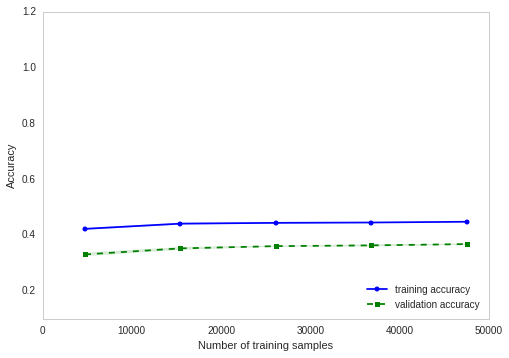

In [12]:
# Perform pre-processing to determine optimal data set size and tune model parameters


# Determine optimal training data set size using learning curve methods
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve

    
train_sizes, train_scores, test_scores = learning_curve(estimator=knn, X=X_train, y=y_train, 
                                                        train_sizes=np.linspace(0.1, 1.0, 5), cv=5)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.1, 1.2])
plt.show()

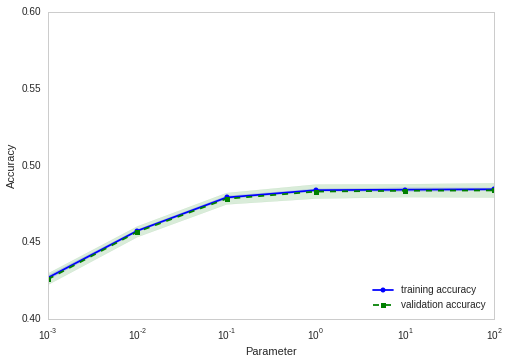

In [13]:
from sklearn.learning_curve import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

train_scores, test_scores = validation_curve(estimator=lr, X=X_train, y=y_train, param_name='C',
                                            param_range=param_range, cv=5)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.xscale('log')
plt.grid()
plt.xlabel('Parameter')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.4, 0.6])
plt.show()

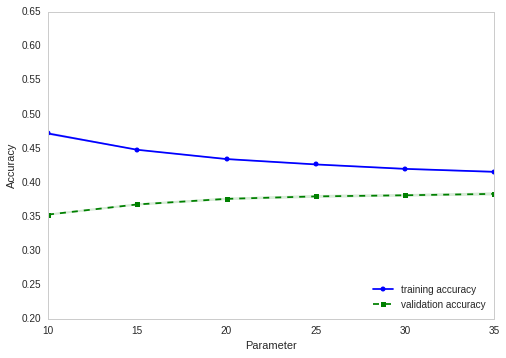

In [14]:
nn_range = [10, 15, 20, 25, 30, 35]
train_scores, test_scores = validation_curve(estimator=knn, X=X_train, y=y_train, param_name='n_neighbors',
                                            param_range=nn_range, cv=5)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(nn_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(nn_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(nn_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(nn_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Parameter')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.20, 0.65])
plt.show()

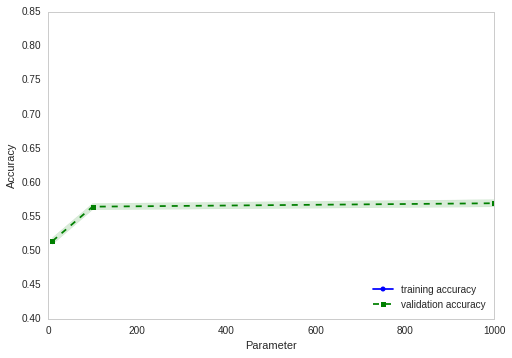

In [15]:
ne_range = [10, 100, 1000]
train_scores, test_scores = validation_curve(estimator=forest, X=X_train, y=y_train, param_name='n_estimators',
                                            param_range=ne_range, cv=5)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(ne_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(ne_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(ne_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(ne_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Parameter')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.40, 0.85])
plt.show()

In [16]:
# in addition to the original data sets for training (train_orig)and testing (test_orig)
# split train_orig data into training and testing sets randomly so we can obtain a practice test set with outcomes
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.30, random_state=0)

In [17]:
# Xgboost 

params = {"objective": "multi:softmax", "num_class": 8}

T_train_xgb = xgb.DMatrix(X_train, y_train)
X_test_xgb  = xgb.DMatrix(X_test)

gbm = xgb.train(params, T_train_xgb, 20)
y_pred = gbm.predict(X_test_xgb)

In [18]:
# change values back to range of values is from 1-8 instead of 0-7

y_pred = y_pred + 1
y_pred = y_pred.astype(int)

In [19]:
# Create submission

output = pd.DataFrame({
        "Id": test_df["Id"],
        "Response": y_pred
    })
output.to_csv("../input/output.csv", index=False)

ValueError: array length 17815 does not match index length 19765